In [1]:
%matplotlib inline

import os
import glob

import pandas as pd
import plotnine as p9
import matplotlib as pyplot
import matplotlib.colors as mcolors
import scipy.stats as ss
from sklearn.metrics import roc_curve

In [2]:
file_tree = {
    "DaG": "../../../disease_gene/disease_associates_gene/edge_prediction_experiment/output/precision_dag_edges_added.tsv",
    "CtD": "../../../compound_disease/compound_treats_disease/edge_prediction_experiment/output/precision_ctd_edges_added.tsv",
    "CbG": "../../../compound_gene/compound_binds_gene/edge_prediction_experiment/output/precision_cbg_edges_added.tsv",
    "GiG": "../../../gene_gene/gene_interacts_gene/edge_prediction_experiment/output/precision_gig_edges_added.tsv"
}

In [3]:
edge_data_tree = {
        key:pd.read_csv(file_tree[key], sep="\t")
        for key in file_tree
}

In [4]:
edge_pred_df = pd.concat([
    edge_data_tree[key].assign(relation=key)
    for key in edge_data_tree
], axis=0)

In [5]:
binned_df = (
    edge_pred_df
    .groupby([
        pd.cut(edge_pred_df.precision, bins=5, duplicates='drop'),
        "in_hetionet",
        "relation"
    ])
    .max()
    .reset_index(level=["in_hetionet", "relation"]) 
    .reset_index(drop=True)
    .append(edge_pred_df.query("precision==1"), sort=True)
    .reset_index(drop=True)
    .dropna()
)

In [6]:
color_map = {
    "Existing":mcolors.to_hex(pd.np.array([178,223,138, 255])/255),
    "Novel": mcolors.to_hex(pd.np.array([31,120,180, 255])/255)
}

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


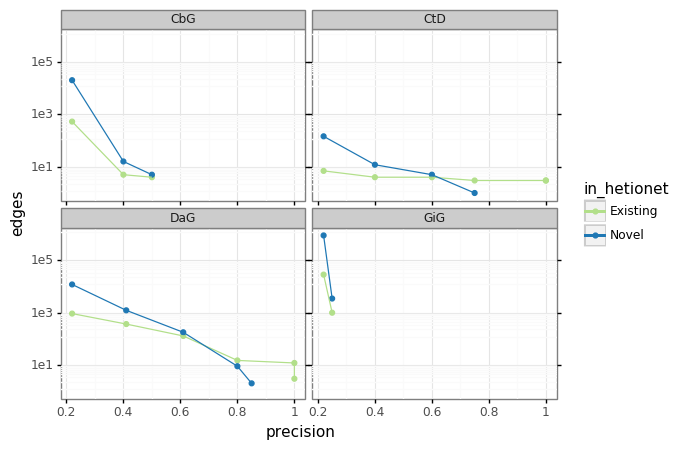

<ggplot: (8734760171931)>


In [7]:
g = (
    p9.ggplot(binned_df, p9.aes(x="precision", y="edges", color="in_hetionet"))
    + p9.geom_point()
    + p9.geom_line()
    + p9.scale_color_manual(values={
        "Existing":color_map["Existing"],
        "Novel":color_map["Novel"]
    })
    + p9.facet_wrap("relation")
    + p9.scale_y_log10()
    + p9.theme_bw()
)
print(g)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


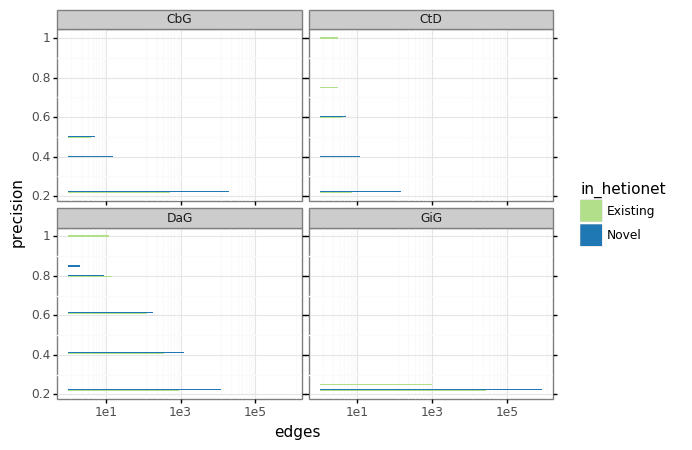

<ggplot: (-9223363302096985919)>


In [8]:
g = (
    p9.ggplot(binned_df, p9.aes(x="precision", y="edges", fill="in_hetionet"))
    + p9.geom_bar(stat='identity', position='dodge')
    + p9.scale_fill_manual(values={
        "Existing":color_map["Existing"],
        "Novel":color_map["Novel"]
    })
    + p9.coord_flip()
    + p9.facet_wrap("relation")
    + p9.scale_y_log10()
    + p9.theme(figure_size=(12,8), aspect_ratio=9)
    + p9.theme_bw()
)
print(g)

In [9]:
combined_sen_tree = {
    "DaG":{
        "file":"../../../disease_gene/disease_associates_gene/edge_prediction_experiment/output/combined_predicted_dag_sentences.tsv.xz",
        "group": ["doid_id", "entrez_gene_id"]
    },
    "CtD":{
        "file":"../../../compound_disease/compound_treats_disease/edge_prediction_experiment/output/combined_predicted_ctd_sentences.tsv.xz",
        "group": ["drugbank_id", "doid_id"]
    },
     "CbG":{
        "file":"../../../compound_gene/compound_binds_gene/edge_prediction_experiment/output/combined_predicted_cbg_sentences.tsv.xz",
        "group": ["drugbank_id", "entrez_gene_id"]
    },
    "GiG":{
        "file":"../../../gene_gene/gene_interacts_gene/edge_prediction_experiment/output/combined_predicted_gig_sentences.tsv.xz",
        "group": ["gene1_id", "gene2_id"]
    }
}

In [10]:
datarows = []
for rel in combined_sen_tree:
    df = pd.read_csv(combined_sen_tree[rel]['file'], sep="\t")
    df = (
        df
        .groupby(combined_sen_tree[rel]['group'])
        .agg({
            "pred": max,
            "hetionet":'first'
        })
        .reset_index()
    )
    
    fpr, tpr, threshold = roc_curve(
        df.hetionet.values,
        df.pred.values
    )

    fnr = 1 - tpr
    optimal_threshold = threshold[pd.np.nanargmin(pd.np.absolute((fnr - fpr)))]
    
    datarows.append({
        "recall":df.query("pred > @optimal_threshold").hetionet.value_counts()[1]/df.hetionet.value_counts()[1],
        "edges":df.query("pred > @optimal_threshold").hetionet.value_counts()[1],
        "in_hetionet": "Existing",
        "relation": rel,
        "total": int(df.hetionet.value_counts()[1])
    })
    datarows.append({
        "edges":df.query("pred > @optimal_threshold").hetionet.value_counts()[0],
        "in_hetionet": "Novel",
        "relation": rel
    })
edges_df = pd.DataFrame.from_records(datarows)
edges_df

,edges,in_hetionet,recall,relation,total
0,6362,Existing,0.690771,DaG,9210.0
1,38680,Novel,NaN,DaG,NaN
2,376,Existing,0.862385,CtD,436.0
3,2909,Novel,NaN,CtD,NaN
4,3562,Existing,0.676672,CbG,5264.0
5,66035,Novel,NaN,CbG,NaN
6,18603,Existing,0.655751,GiG,28369.0
7,305830,Novel,NaN,GiG,NaN


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


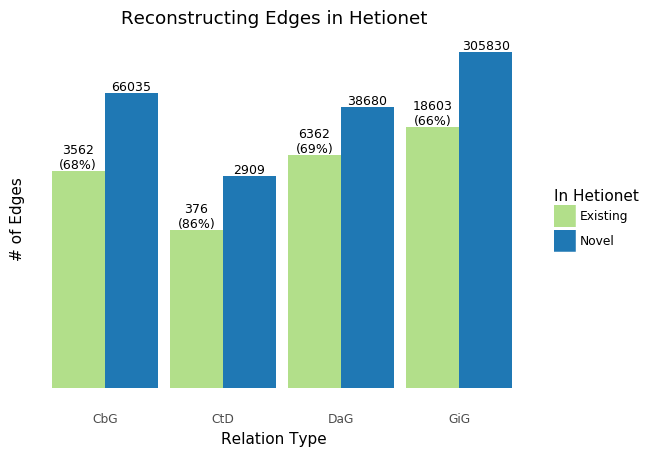

<ggplot: (-9223363302094602352)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../edges_added.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plot

In [11]:
import math
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.scale_fill_manual(values={
        "Existing":color_map["Existing"],
        "Novel":color_map["Novel"]
    })
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df
                .apply(
                    lambda x: 
                    f"{x['edges']}\n({x['recall']*100:.0f}%)" 
                    if not math.isnan(x['recall']) else 
                    f"{x['edges']}",
                    axis=1
                )
            )
        ),
        position=p9.position_dodge(width=0.9),
        size=9,
        va="bottom"
    )
    + p9.scale_y_log10()
    + p9.labs(
        y = "# of Edges",
        x = "Relation Type",
        title="Reconstructing Edges in Hetionet"
    )
    + p9.guides(fill=p9.guide_legend(title="In Hetionet"))
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major = p9.element_blank(),
        rect=p9.element_blank(),
    )
)
print(g)
g.save(filename="../edges_added.png", dpi=300)